In [3]:
### Load libraries ###

# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller

from sklearn.neural_network import MLPRegressor
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn import set_config
set_config(display='diagram')
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})


# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
import scipy as sp

# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime
import scipy.stats as st

torch installation could not be found, only numpy activation functions allowed


---
## 1. Read the dataset

Indicamos que la variable date tiene fechas (parse_dates), para decirle que no es una variable mas sino que es un indice de fechas. Al leer el df, no está como una variable sino como un indice. 

In [4]:
# Import data
dateparse = lambda x :datetime.strptime(x ,"%d/%m/%Y")

df = pd.read_csv('UnemploymentSpain.dat',sep='\t')#, parse_dates=['DATE'], dayfirst=True, date_parser=dateparse, index_col='DATE')

df.head()

,DATE,TOTAL
0,01/01/2001,2017389
1,01/02/2001,1993273
2,01/03/2001,1981006
3,01/04/2001,1910453
4,01/05/2001,1898285


In [5]:
df.shape

(262, 2)

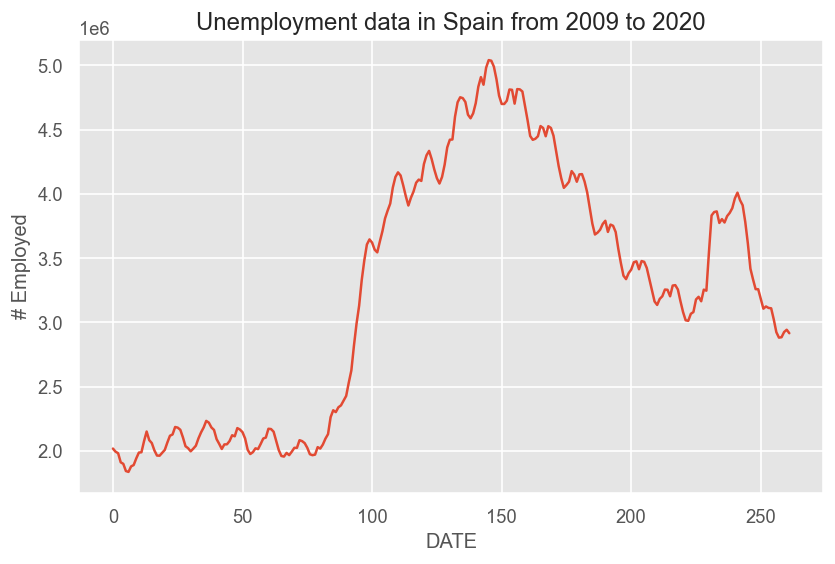

In [6]:
# Plotting a time series
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2009 to 2020', xlabel='DATE', ylabel='# Employed')
plt.show()

Vemos que no hay constancia ni en la media ni en la varianza, por lo que deberemos estabilizarlas

In [7]:
df_uneployment = df[['TOTAL']] # Maintain data.frame format for column
df_uneployment

,TOTAL
0,2017389
1,1993273
2,1981006
3,1910453
4,1898285
...,...
257,2880582
258,2883812
259,2924240
260,2941919


Viendo esta serie, aun no puedo saber si es autorregresiva, ruido blanco o lo que sea.

---
### Identification process

Con esta funcion, lo que estamos pintando es la serie original y las funciones de correlacion simple parcial (acf y pacf)

Los pasos a seguir son:
- 1. Identificacion (ACF yPACF)
    - Aqui vemos que la primera barra llega hasta 1, no le tenemos que hacer caso porque está enseñando la correlacion consigomismo
    - Vemos que no es ruido blanco porque tenemos correlaciones fuera de la banda del 0.
    - Si nos fijamos en el ACF sería un MA2 o 3, pero si nos fijamos en el PACF sería un AR1
- 2. Diagnostico
    - Ajustamos un modelo con AR1 para ver si es un modelo adecuado. Hemos visto que puede ser cualquiera de las dos opciones (AR1 o MA2), esogeremos el mas sencillo de primeras
    - AR tiene un parámetro, mientras que MA2 tiene 2 parámetros que estimar, asíque empezamos ajunstando el modelo AR1.

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


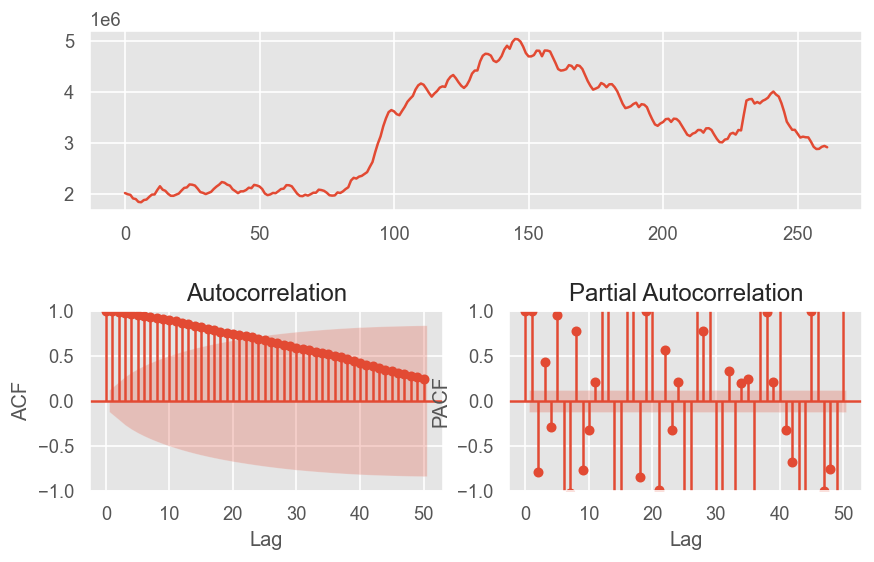

In [8]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_uneployment,lags=50)

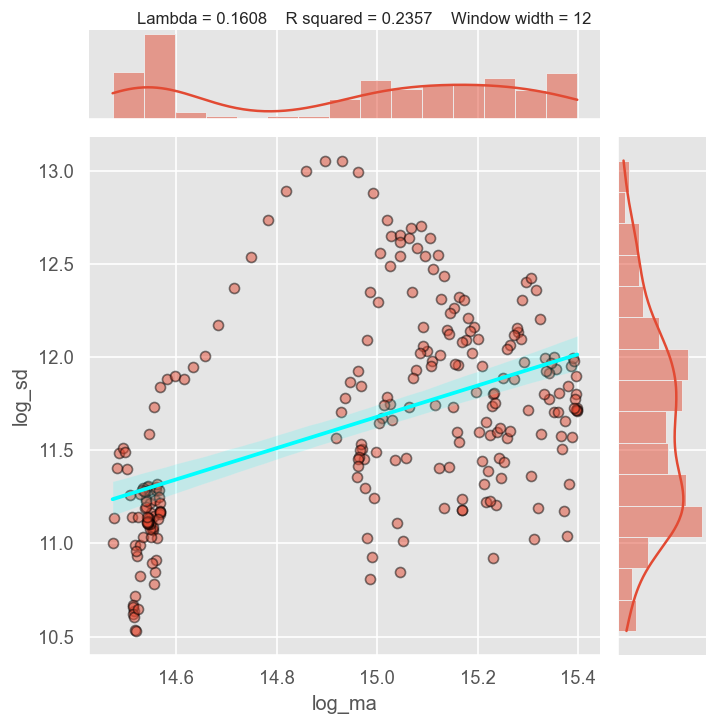

0.1607915855603168

In [9]:
FT.boxcox_lambda_plot(df_uneployment, window_width=12)

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


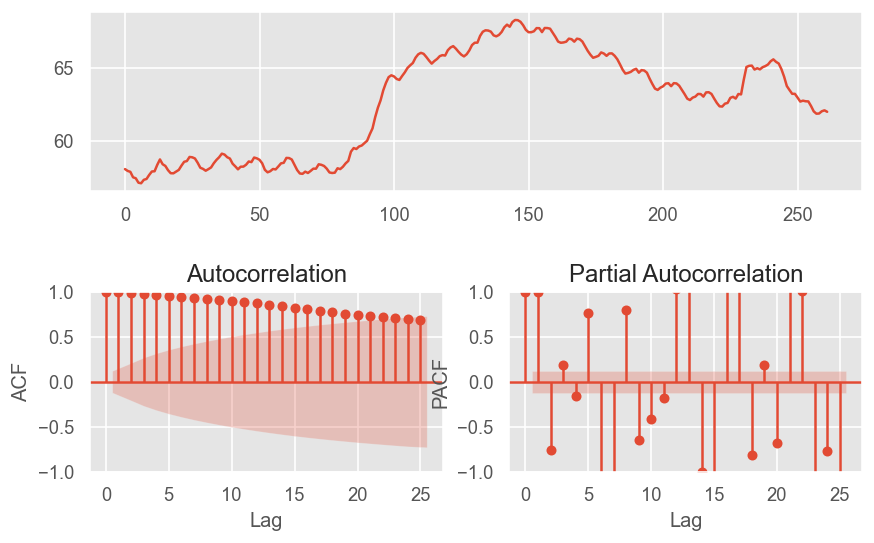

In [10]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.161 #Select lambda
    z = st.boxcox(df_uneployment.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_uneployment.columns.values.tolist())
else:
    z = df_uneployment

# Plot transformed data
FT.ts_display(z)

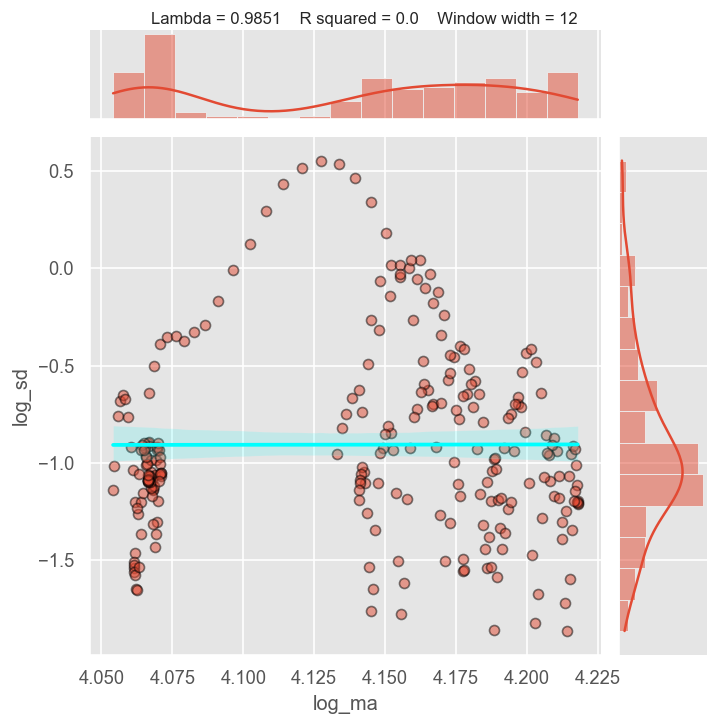

0.9850716550948463

In [11]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [12]:
# Alternative test - Augmented Dickey Fuller Test
# Aplicando este test, podemos saber si debemos realizar diferenciacion para la media o no. Si el pvalor es mayor de 0.05, se realiza diferenciacion
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.644424
p-value: 0.459950
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


Como el pvalor es mayor que 0.05, se realiza diferenciacion en la media

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


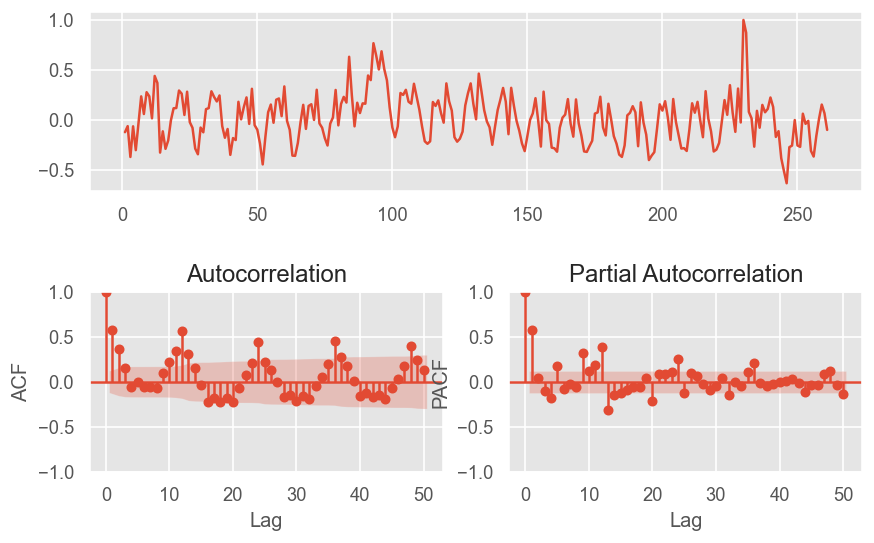

In [13]:
# Difference of the time series
d = 1 # diferenciacion regular. hacer iT y iT-1, si es dos cambiaria a 2
D = 0 # diferenciacion estacional. obterner mnueva seria q es iT - (iT-s)
S = 12 # Seasonality of 6 days
# 1,0,12 ves que tienes una tendencia estacional, no es estacionaria porq no decrece, asi que tienes que aumentar la
# diferenciacion estacional
# es la diferencia combinada entre el mes anterior y el año anterior

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)
# ACF tienes una barra y 3 significativa en el PACF, estacionalmente puede ser una media movil estacional

En primer lugar vemos que con D = 0, obtenemos un seasonality de 12 (hay un pico cada 12 puntos)

Debemos hacer esto para establecer la seasonality. Lo hacemos con 0 para ver, y luego ya hacemos la transformacion boxcox con la seasonality que hayamos descubierto en este gráfico

In [14]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,1,0), # Regular components
                     # AR,si haces diferenciacion(d),MA
                     # primeros coeficiente en ACF y PACF. solo t fijas en los primeros coeficientes de PACF. AR orden 2
                    seasonal_order=(2, 1, 0, 12), # Seasonal components, (P, D, Q(MA), S)
                     # En el Q es donde hay mas simple, PACF en los multiplos de 12 hay 3 pero en el ACF solo hay 1
                     
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  262
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 110.528
Date:                            Fri, 25 Nov 2022   AIC                           -213.056
Time:                                    10:46:38   BIC                           -199.410
Sample:                                         0   HQIC                          -207.548
                                            - 262                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6720      0.027     24.482      0.000       0.618       0.726
ar.S.L12      -0.6168      0.032   

c:\Users\marti\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  26.039558    0.40549


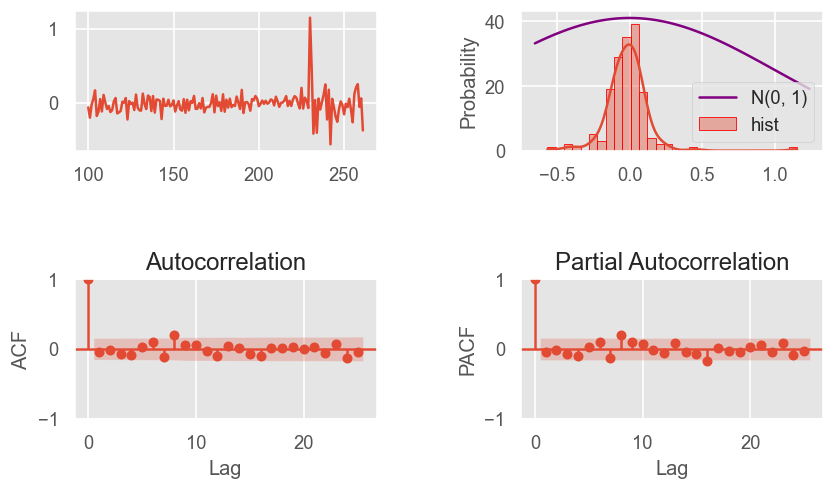

In [15]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

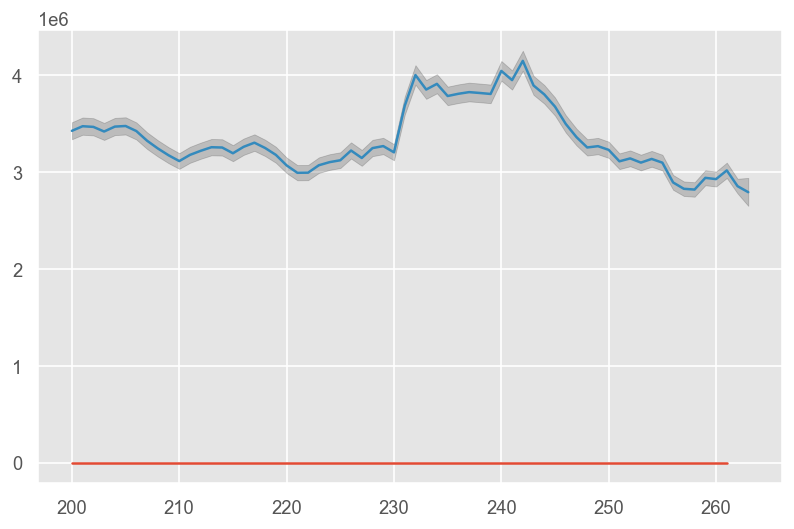

In [16]:
#Obtain forecasts for in-sample and out-of-sample
start = 200
horizon = 1
end = z.shape[0] + horizon

pred = sarima_fit.get_prediction(start = start, end=end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(z.loc[start:])
plt.plot(yhat)

In [24]:
# ¿Cómo hacemos para sacar el numerito de la prediccion?

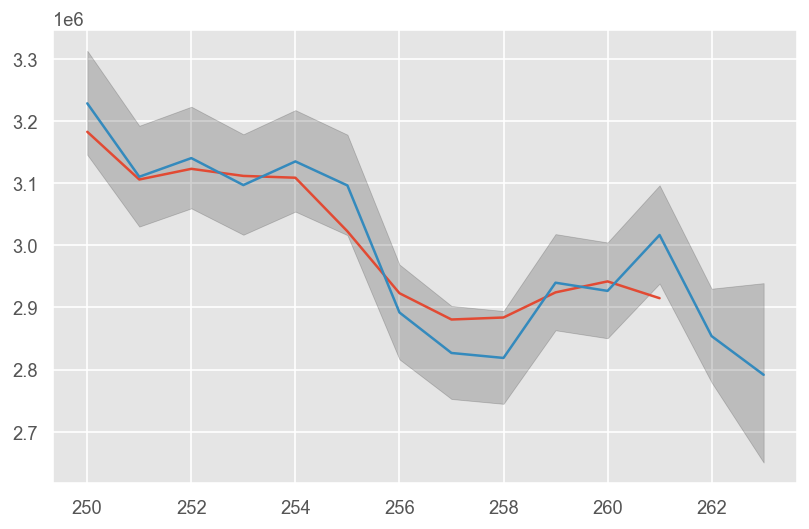

In [23]:
#Obtain forecasts for in-sample and out-of-sample
start = 250
horizon = 1
end = df_uneployment.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)



plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_uneployment.loc[start:])
plt.plot(yhat)
plt.show()